# 1.Dataset

##install Dependencies

In [19]:
import tensorflow as tf
import os

In [20]:
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

##Remove dodgy image

In [21]:
import cv2
import imghdr

In [22]:
data_dir='Data'
os.listdir(data_dir)

['Ford']

In [23]:
image_exts=['jpeg','jpg','bmp','png']

In [24]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img=cv2.imread(image_path)
      tip=imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not exit list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

Image not exit list Data\Ford\1200px-1928_Model_A_Ford.jpg


Image not exit list Data\Ford\640px-2010_Ford_Taurus_Limited_2_--_10-31-2009.jpg
Image not exit list Data\Ford\ford-ranger-lariat-2024-01-exterior-front-angle-blue-scaled.jpg
Image not exit list Data\Ford\front-left-side-47.jpg


##Load data

In [25]:
from matplotlib import pyplot as plt
import numpy as np

In [26]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 83 files belonging to 1 classes.


In [27]:
data_iterator=data.as_numpy_iterator()

In [28]:
batch =data_iterator.next()

In [29]:
batch[0].shape

(32, 256, 256, 3)

In [30]:
batch[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

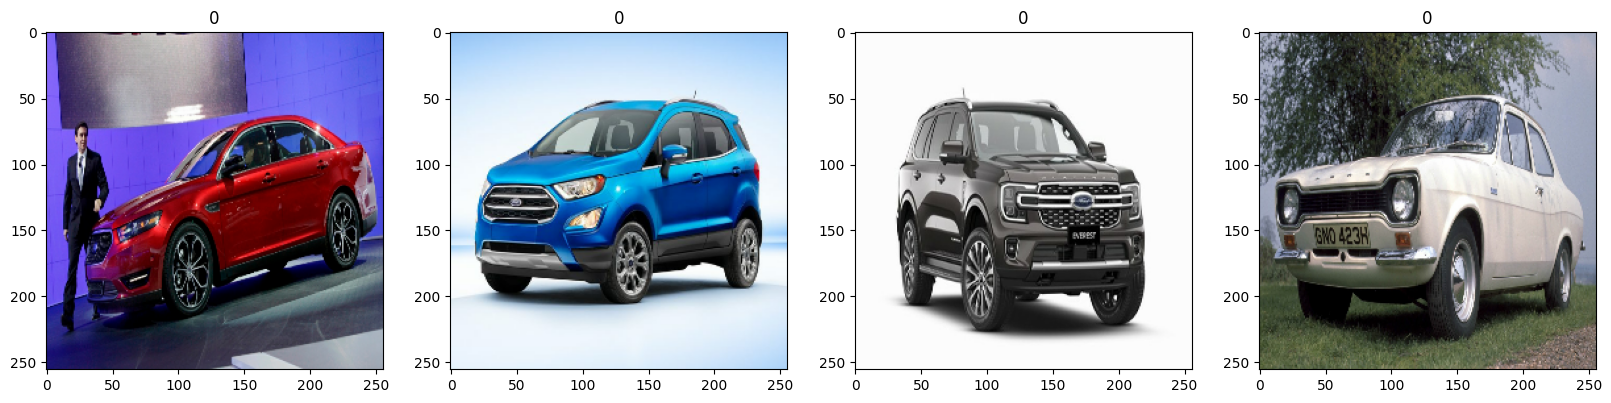

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# 2.Preprocess data

##Scal dataset

In [32]:
data = data.map(lambda x,y: (x/255,y))

In [33]:
scaled_iterator=data.as_numpy_iterator()

In [34]:
batch=scaled_iterator.next()

In [35]:
batch[0].max()

1.0

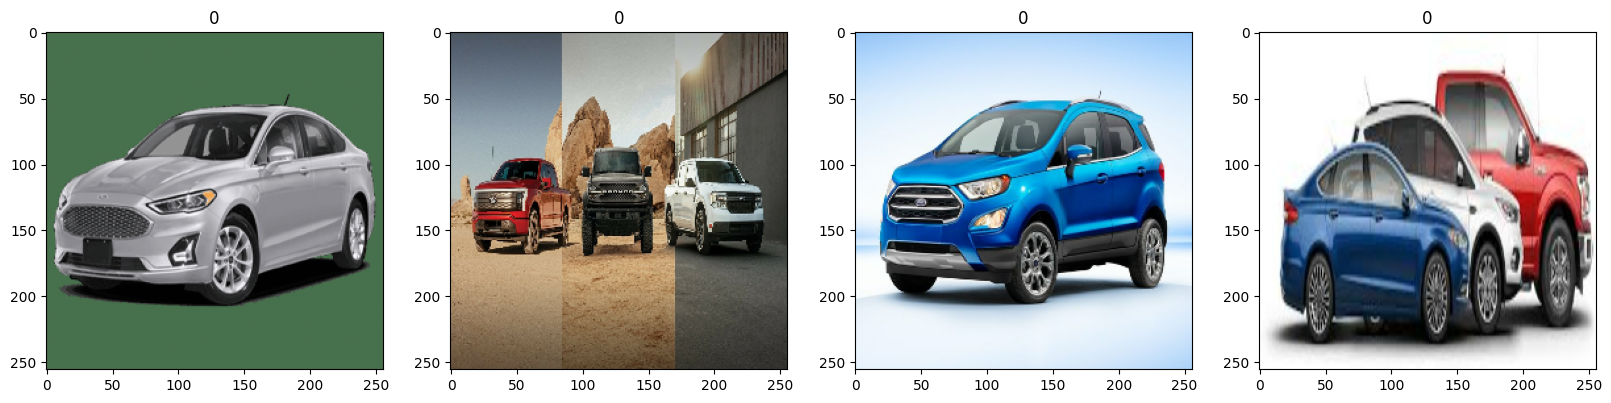

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

##Split data

In [37]:
len(data)

3

In [38]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [39]:
train_size+val_size+test_size

3

In [40]:
train=data.take(train_size)
val = data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [41]:
len(train)

2

#3.Deep model

##Build model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [43]:
model = Sequential()

# Step 1 - Convolution
# Use ReLU (rectifier function) to delete negative pixels to avoid non linearities
model.add(Conv2D(16, (3, 3), 1, input_shape = (256, 256, 3),
                             activation = 'relu'))
model.add(MaxPooling2D())

# Step 2 - Pooling
model.add(Conv2D(32, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

# Adding a second convolutional layer
model.add(Conv2D(16, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full connection

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))# get a summary of the model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

##4.Train

In [44]:
logdir='logs'

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [46]:
hist=model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2/2 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.9375

ValueError: Expected input data to be non-empty.

##Diagram table

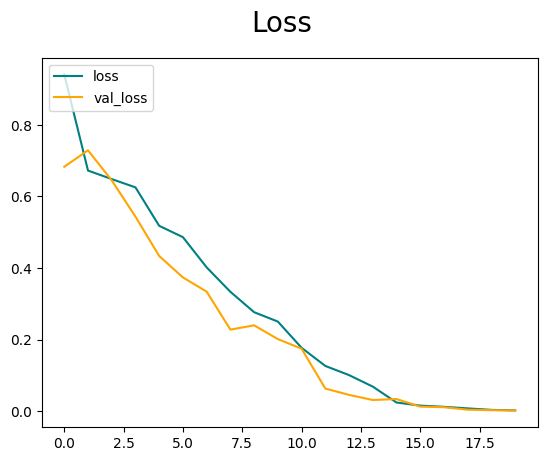

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

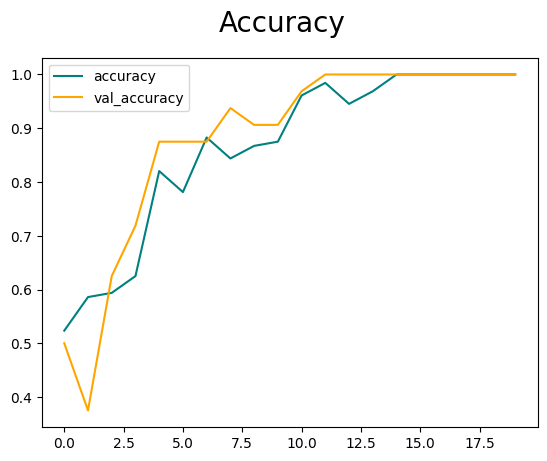

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#4.Evaluation Image

##Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
len(test)

1

In [ ]:
for batch in test.as_numpy_iterator():
  x,y = batch
  yhat = model.predict(x)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 1s 518ms/step


In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


##Test

In [ ]:
import cv2

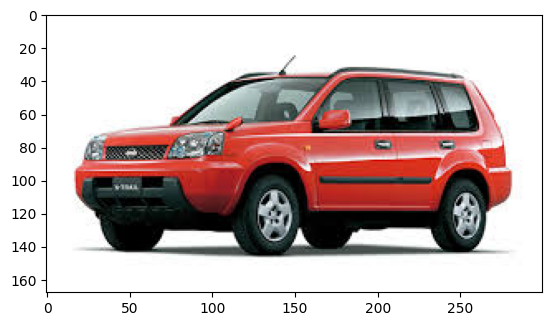

In [ ]:
img = cv2.imread('Nissan_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

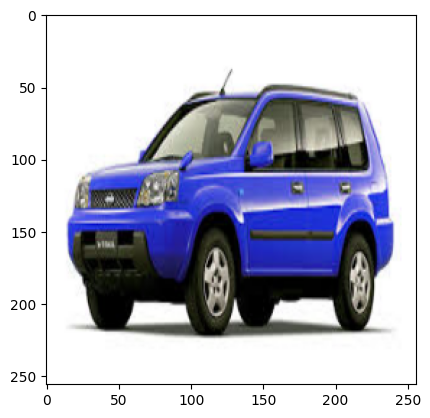

In [ ]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 115ms/step


array([[0.9772385]], dtype=float32)

In [ ]:
if yhat > 0.5:
  print("Cat")
else:
  print("Dog")

Dog
